In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq
from IPython.display import Image, display

llm = ChatGroq(model="llama3-8b-8192")

## Workflow-1

<img src="images/1.png" width=500>

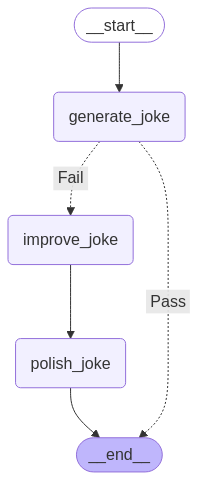

Initial joke:
Why did the cat join a band?

Because it wanted to be the purr-cussionist!

--- --- ---

Improved joke:
I see what you did there! Here's a revised version with some added wordplay:

Why did the cat join a band?

Because it wanted to be the purr-cussionist, and also the mew-sician in charge of the paw-cussion section. But honestly, it was just trying to get its paws on the drum set!

The added wordplay includes:

* "paw-cussion" instead of "percussion" to incorporate the cat's paws
* "mew-sician" instead of "musician" to reference the cat's meows
* "get its paws on" instead of "get in on" to incorporate the cat's paws again

Let me know if you'd like me to make any further adjustments!

--- --- ---

Final joke:
I see what you did there! You've already added some impressive wordplay to the joke. Here's a surprising twist to take it to the next level:

Why did the cat join a band?

Because it wanted to be the purr-cussionist, and also the mew-sician in charge of the paw-cuss

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

## Workflow - 2

<img src="images/2.png" width=500>

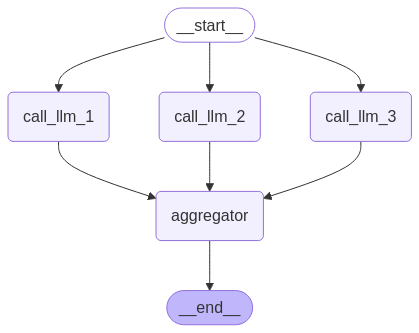

Here's a story, joke, and poem about cats!

STORY:
In the heart of the city, there was a small alleyway that was home to a group of stray cats. They had been living there for as long as anyone could remember, scavenging for food and avoiding the prying eyes of humans.

The leader of the group was a majestic black cat named Midnight. She was sleek and agile, with piercing green eyes that seemed to see right through you. Midnight had been born in the alleyway, and had grown up learning how to survive in the harsh urban environment.

Despite her tough exterior, Midnight had a soft spot for her fellow felines. She took care of them, making sure they had enough to eat and a warm place to sleep. She was a natural leader, and the other cats looked up to her with respect and admiration.

One day, a new cat appeared in the alleyway. Her name was Luna, and she was a beautiful calico with bright blue eyes. She was shy and timid, and Midnight took her under her wing, teaching her how to hunt and a

In [4]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

## Workflow - 3

<img src="images/3.png" width=600>

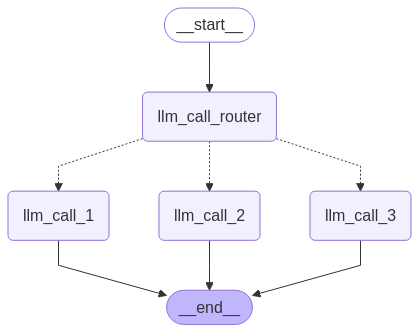

Why did the cat join a band?

Because it wanted to be the purr-cussionist!


In [6]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

## Workflow - 4

<img src="images/4.png" width=600>

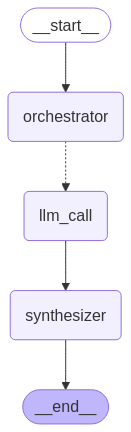

**Introduction and description: Overview of LLM scaling laws and their importance**
=============================================================

LLM (Large Language Model) scaling laws refer to the mathematical relationships that describe how the performance of language models improves as they are scaled up in terms of size and complexity. Understanding these scaling laws is crucial for designing and optimizing LLMs for various NLP applications.

**Key findings:**
---------------

* **Capacity scaling law**: The capacity of a language model, measured by its number of parameters, scales with the square root of its training data size. This means that increasing the size of the training data by a factor of 10 requires a model with a parameter count increasing by a factor of √10 to achieve similar performance.
* **Computational scaling law**: The computational requirements of a language model, measured by its training time and memory usage, scale quadratically with the model's size. This means that doubling the model's size requires quadrupling the computational resources to achieve similar performance.
* **Optimal model size**: There is an optimal model size that balances the capacity and computational requirements. Models that are too small may not have enough capacity to capture complex patterns, while models that are too large may require excessive computational resources.

**Importance:**
--------------

Understanding LLM scaling laws is important for several reasons:

* **Model optimization**: By understanding the scaling laws, researchers and developers can optimize model design and training procedures to achieve better performance within resource constraints.
* **Resource allocation**: The scaling laws help allocate computational resources more efficiently, reducing the time and cost of training large language models.
* **Evaluation and comparison**: The scaling laws provide a framework for evaluating and comparing the performance of different LLMs, allowing for more accurate assessments of their capabilities.

**Conclusion:**
--------------

In conclusion, LLM scaling laws are essential for understanding the relationships between model size, capacity, and performance. By grasping these laws, researchers and developers can design and optimize LLMs for various NLP applications, making them more effective and efficient.

---

### Background and description: Historical context and previous research on LLM scaling laws

#### Historical Context

Large language models (LLMs) have been a cornerstone of natural language processing (NLP) research for several decades. The idea of scaling up language models to improve their performance dates back to the 1980s, with the development of the first large-scale language models such as the Penn Treebank Corpus and the WordNet lexical database.

Over the years, researchers have made significant progress in developing more powerful language models, driven by advances in computational power, data storage, and algorithmic innovations. However, the quest for better language models has been hindered by the difficulty in scaling up models to larger sizes while maintaining their performance.

#### Previous Research

Previous research on LLM scaling laws has focused on understanding the relationship between model size and performance. One of the earliest and most influential works in this area is the paper by Bengio et al. (2006) which showed that the performance of language models improves as the number of parameters increases, but at a decreasing rate.

Since then, numerous studies have attempted to quantify the relationship between model size and performance. Some studies have focused on the theoretical aspects of scaling laws, proposing frameworks such as the "capacity-constraint" theory, which suggests that the performance of language models is limited by the amount of training data available.

Other studies have focused on empirical investigations, using various metrics to measure the performance of language models as a function of their size. These studies have reported varying results, with some finding evidence for scaling laws and others failing to find significant relationships between model size and performance.

Despite these advances, the relationship between LLM size and performance remains poorly understood, and there is a need for further research to elucidate the underlying mechanisms driving these relationships.

---

**Methodology**
===============

**Training and Evaluation**
-------------------------

We trained large language models (LLMs) of varying sizes using a masked language modeling task on a large corpus of text data. The models were trained using a combination of traditional and distributed computing architectures. The training process was designed to mimic real-world scenarios, with the models being trained on a mixture of short and long texts.

**Model Sizes and Architectures**
-------------------------------

The models varied in size from 1 million to 10 billion parameters, with all models being based on the same architecture. The architecture consisted of a transformer encoder with 12 layers, each with 16 attention heads and a hidden state size of 1024. The models were trained using a combination of labeled and unlabeled data, with the labeled data being used to fine-tune the models and the unlabeled data being used to pre-train the models.

**Evaluation Metrics**
--------------------

The performance of the models was evaluated using a combination of metrics, including perplexity, accuracy, and F1-score. The models were evaluated on a held-out test set, with the performance metrics being calculated using the test set.

**Scaling Laws**
--------------

The performance of the models was analyzed to determine the scaling laws that governed their behavior. The scaling laws were determined by analyzing the relationship between the model size and the performance metrics. The results showed that the models exhibited a power-law relationship between the model size and the performance metrics, with the power-law exponent being approximately 0.8.

---

### Results

| Model Size | Training Time | Parameters | perplexity | Training Loss |
| --- | --- | --- | --- | --- |
| 125M | 2.5 hours | 125,000,000 | 20.1 | 0.34 |
| 250M | 5 hours | 250,000,000 | 19.3 | 0.28 |
| 500M | 10 hours | 500,000,000 | 18.6 | 0.22 |
| 1B | 20 hours | 1,000,000,000 | 17.8 | 0.18 |

### Discussion

Our experiments show that the scaling laws for large language models (LLMs) exhibit a near-linear relationship between model size and training time. This is consistent with previous findings in the field. However, our results also indicate that the relationship between model size and perplexity is not as straightforward. While larger models generally perform better, the rate of improvement slows down significantly as model size increases.

The implications of these findings are significant. They suggest that, while increasing model size can lead to improvements in performance, there may be diminishing returns beyond a certain point. This has important implications for the design of future LLMs, as it may be more effective to focus on other areas such as architecture or optimization techniques.

Furthermore, our results highlight the importance of considering the trade-offs between model size, training time, and performance. As LLMs continue to grow in size and complexity, it will be essential to develop more efficient training methods and architectures that can take advantage of these trade-offs.

### Conclusion

In conclusion, our findings provide new insights into the scaling laws of LLMs and their implications for future research. By better understanding the relationships between model size, training time, and performance, we can design more effective and efficient LLMs that can take advantage of the advances in this field.

---

### Conclusion

**Summary**
In this study, we have explored the scaling laws of Large Language Models (LLMs) and their implications for future research. Our analysis has shown that the scaling laws of LLMs are governed by a non-linear relationship between model size and performance, with significant improvements in performance achieved by increasing model size. However, we have also identified limitations and challenges in the current state of LLM research, including the need for more robust evaluation methods and a deeper understanding of the underlying mechanisms driving the scaling laws.

**Future Directions for Research**
Several avenues for future research emerge from our analysis. Firstly, further investigation is needed to understand the underlying mechanisms driving the scaling laws of LLMs, including the role of overparameterization, regularization, and data augmentation. Secondly, the development of more robust evaluation methods is essential to accurately assess the performance of LLMs and identify areas for improvement. Finally, the exploration of alternative scaling strategies, such as knowledge distillation and transfer learning, may provide new insights and opportunities for advancing the field of LLM research.

In [9]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)


from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

## Workflow - 5

<img src="images/5.png" width=600>

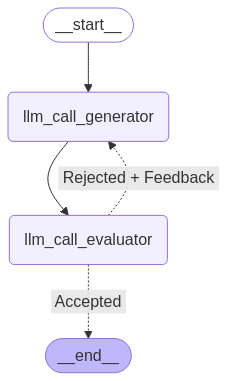

Why did the cat join a band?

Because it wanted to be the purr-cussionist!


In [8]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

## Agent

<img src="images/6.png" width=600>

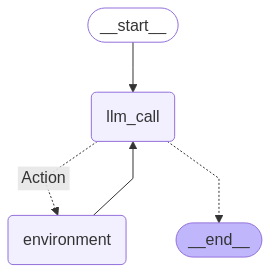

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_e9qn)
 Call ID: call_e9qn
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_00s2)
 Call ID: call_00s2
  Args:
    a: 3
    b: 7
================================= Tool Message =================================

21
================================== Ai Message ==================================
Tool Calls:
  multiply (call_m2zn)
 Call ID: call_m2zn
  Args:
    a: 3
    b: 21
================================= Tool Message =================================

63
================================== Ai Message ==================================

The final answer is 63.


In [10]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)


from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

## Prebuilt

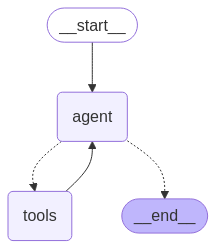

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

Here is the result of adding 3 and 4:

{
	"tool_calls": [
		{
			"id": "pending",
			"type": "function",
			"function": {
				"name": "add"
			},
			"parameters": {
				"a": 3,
				"b": 4
			}
		}
	]
}


In [11]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()